In [10]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 7.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt', sep = '\t')
data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


## 데이터 전처리

In [3]:
# 결측치 처리
data.isnull().sum()

,0
id,0
document,8
label,0


In [4]:
data.dropna(inplace = True)

In [5]:
# 이상치 처리
sentence_length = data['document'].apply(lambda x: len(x)) # 문장길이
spacing_count = data['document'].apply(lambda x: len(x.split())) # 띄어쓰기 횟수

<Axes: ylabel='Frequency'>

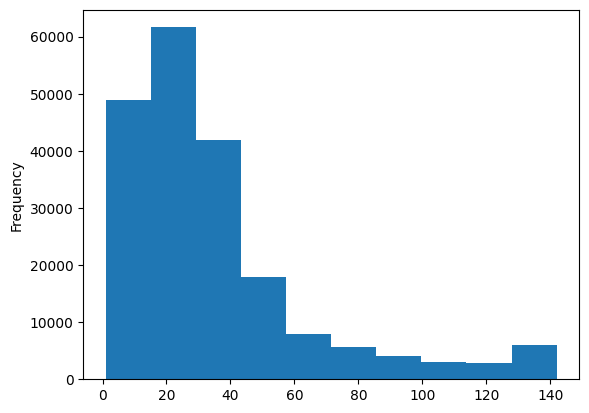

In [6]:
sentence_length.plot.hist()

<Axes: ylabel='Frequency'>

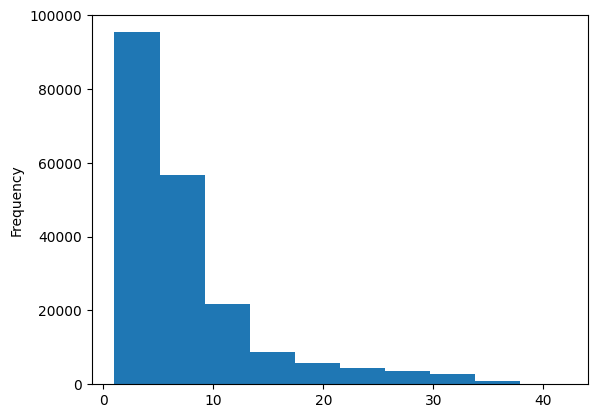

In [7]:
spacing_count.plot.hist()

In [8]:
# 이상치 처리
data = data[sentence_length < 120]

In [11]:
from konlpy.tag import Okt
import re
okt = Okt()

stopwords = pd.read_csv('stopword_kr.txt')['stopword'].tolist()

def text_preprocessing(text):
    cleaned_text = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", text) # 특수문자 제거
    words = okt.morphs(cleaned_text, stem = True) # 토큰화(형태소 분석)
    words = [word for word in words if not word in stopwords] # 불용어 제거
    return words

In [12]:
# data['tokenized_document'] = data['document'].apply(lambda x: text_preprocessing(x))
# tokenized_data = data['tokenized_document'].to_list()

In [13]:
# 강사의 데이터를 불러오는 경우
tokenized_data = pd.read_pickle('tokenized_data.pkl')

## Word2Vec 모델 생성

In [14]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data,
                 vector_size = 100,
                 window = 5,
                 min_count = 5,
                 workers = 4, sg = 0)

In [15]:
# 모델 저장
model.wv.save_word2vec_format('Word2Vec_100.model')

In [16]:
model.wv.most_similar('노잼')

[('핵', 0.7856706380844116),
 ('노답', 0.749415397644043),
 ('깜놀', 0.741953432559967),
 ('셈', 0.7074326872825623),
 ('꿀잼', 0.7026147246360779),
 ('우와', 0.6934213638305664),
 ('개핵', 0.6856629252433777),
 ('ㅋㅋㅋㅋㅋㅋㅋ', 0.6801723837852478),
 ('열자', 0.6800636649131775),
 ('개꿀잼', 0.6700345277786255)]

In [17]:
vocab = list(model.wv.key_to_index)
word_vectors = model.wv.vectors

In [18]:
# PCA 차원축소
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
word_vectors_2d = pca.fit_transform(word_vectors)

In [19]:
import pandas as pd
df = pd.DataFrame(word_vectors_2d, columns = ['x', 'y'])
df['word'] = vocab
df.head()

,x,y,word
0,2.136851,-0.363675,영화
1,-0.927549,-1.443503,보다
2,5.044139,-3.238165,을
3,3.122085,0.441240,없다
4,1.134101,0.074443,이다


In [20]:
# x and y given as DataFrame columns
import plotly.express as px
fig = px.scatter(df.head(1000), x="x", y="y", text = 'word')
fig.update_traces(textposition='top center')
fig.show()

In [21]:
!python -m gensim.scripts.word2vec2tensor --input Word2Vec.model --output Word2vecTSV

2024-11-26 06:49:48,950 - word2vec2tensor - INFO - running /usr/local/lib/python3.10/dist-packages/gensim/scripts/word2vec2tensor.py --input Word2Vec.model --output Word2vecTSV
2024-11-26 06:49:48,951 - keyedvectors - INFO - loading projection weights from Word2Vec.model
2024-11-26 06:49:51,203 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (16470, 100) matrix of type float32 from Word2Vec.model', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-11-26T06:49:51.199414', 'gensim': '4.3.3', 'python': '3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]', 'platform': 'Linux-6.1.85+-x86_64-with-glibc2.35', 'event': 'load_word2vec_format'}
2024-11-26 06:49:52,793 - word2vec2tensor - INFO - 2D tensor file saved to Word2vecTSV_tensor.tsv
2024-11-26 06:49:52,793 - word2vec2tensor - INFO - Tensor metadata file saved to Word2vecTSV_metadata.tsv
2024-11-26 06:49:52,794 - word2vec2tensor - INFO - finished running word2vec2tensor.py
